# Import

In [1]:
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math
import pandas as pd
from plotnine import *
from tqdm import tqdm_notebook as tqdm

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla
print('IMPORT DONE')

IMPORT DONE


# Car Environment [Action/Reward here]

In [2]:
class CarEnv:
    #BRAKE_AMT = 1.0

    actor_list = []
    collision_hist = []

    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)

        self.world = self.client.get_world()

        blueprint_library = self.world.get_blueprint_library()

        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
    
    def Black_screen(self):
        settings = self.world.get_settings()
        settings.no_rendering_mode = True
        self.world.apply_settings(settings)
        
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        #place=random.uniform(110,150)
        ##print('Location: ',str(place))
        transform = carla.Transform(carla.Location(-120,125,3),carla.Rotation(0,-90,0))

        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        
        self.actor_list.append(self.vehicle)

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')

        transform = carla.Transform(carla.Location(x=0, z=1.9))
        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)

        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        self.episode_start = time.time()


        time.sleep(4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle is None:
            time.sleep(0.01)

        self.episode_start = time.time()

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        
        return abs(float("%.1f" % self.distance_to_obstacle))

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        lidar_data = points.astype(np.int32)
        self.pt_cloud.append(lidar_data)

        #screen points specifically -4<y<4 and 0<x<12
        pt = points[np.logical_and(points[:,0] > -3, points[:,0] < 3)]
        points_filter = pt[np.logical_and(pt[:,1] > 0, pt[:,1] < 50)]
        points_filter = points_filter[np.logical_and(points_filter[:,1] > 0, points_filter[:,1] < 50)]
        self.pt_cloud_filtered.append(points_filter)

        if len(points_filter) == 0:
            pass
        else:
            self.distance_to_obstacle = min(points_filter[:,1])-2.247148275375366

    def step(self, action):

        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0))
        elif action == 1:
            while kmh != 0:
                self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=1.0, steer = 0.0))
                v = self.vehicle.get_velocity()
                kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
                #print("distance_to_obstacle = ",self.distance_to_obstacle)
                
        # ถ้ารถชน หรือ รถหยุดแล้ว
        if kmh == 0 or len(self.collision_hist) != 0 :
            done = True
        
            if  0<= self.distance_to_obstacle <1 and len(self.collision_hist) != 0 :
                reward = -1
            elif  0<= self.distance_to_obstacle <1:
                reward = 1
            elif  1<= self.distance_to_obstacle <2:
                reward = 1.5
            elif  2<= self.distance_to_obstacle <3:
                reward = 0.45
            elif  3<= self.distance_to_obstacle <4:
                reward = 0.32
            elif  4<= self.distance_to_obstacle <5:
                reward = 0.20
            elif  5<= self.distance_to_obstacle <6:
                reward = -0.15
            elif  6<= self.distance_to_obstacle <7:
                reward = -0.8
            elif  7<= self.distance_to_obstacle <8:
                reward = -1.5
            elif  8<= self.distance_to_obstacle :
                reward = -3
        else:
            done = False
            reward = 0.5
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            reward = -1
            dist = 0
            
        dist=abs(float("%.1f" % self.distance_to_obstacle))
            

        return dist,reward, done, None

# Optional Function

In [3]:
def open_carla(require):
    try:
        if require == 'fast':
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe -benchmark  -fps=10 -quality-level=Low')
        else:
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe')
    except Exception as err:
        print(err)
    print('opening Carla')
    
def close_carla():
    try:
        os.system('TASKKILL /F /IM CarlaUE4.exe')
    except Exception as err:
        print(err)
    time.sleep(0.5)
    
def xxx():
    env.world.wait_for_tick()
    for x in list(env.world.get_actors()):
        if x.type_id == 'vehicle.tesla.model3' or x.type_id == 'sensor.lidar.ray_cast' or x.type_id == 'sensor.other.collision':
            x.destroy()
            
def lidar_line(points,degree,width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1.75, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

def update_q(state,new_state,action,reward):
    global learning_rate,discount_rate,q_table,dist_q
    if state == new_state:
        if state in dist_q  :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)        
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
    else:
        if state in dist_q and new_state in dist_q :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif state in dist_q :
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(new_st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif new_state in dist_q:
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table.insert(new_st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        


# Input

In [4]:
# action มี 2 อันคือ เบรคและเร่งเต็มที่, state มี 13 อัน คือ ชน, 0-1, 1-2, 2-3, 3-4, 4-5, 5-6, 6-7, 7-8, 8-9, 9-10, 10-11, >11
action_space_size = 2
state_space_size = 10

#q_table = np.zeros((state_space_size, action_space_size))

num_episodes = 700
max_steps_per_episode = 100
learning_rate = 0.1
discount_rate = 0.99
SECONDS_PER_EPISODE=12
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

count = 0


# Load q_table

In [5]:
load = True

if load == True:
    model_name='brake_test_1'
    file_path="DATA\\ "
    df_q=pd.read_csv(file_path+'{}_q_table.csv'.format(model_name))
    dist_q_load=df_q.values[:,0]
    q_table_load=df_q.values[:,1:]
    df_load=pd.read_csv(file_path+'{}.csv'.format(model_name))
    value=['Episode','Reward','avg_reward','Step','stop_distance','Explore','PCT_Explore']
    df_load=df_load[value]
    load_ep=df_load.Episode.tail(1).values[0]+1
    load_explore=df_load.Explore.tail(1).values[0]

# MAIN

In [6]:
#IN CASE Train from LOAD q_table 
if load == True:
    q_table=np.ndarray.tolist(q_table_load)
    dist_q =np.ndarray.tolist(dist_q_load)
    exploration_rate = load_explore
    
else :
    q_table = []
    dist_q=[]
    load_ep=0

rewards_all_episodes = []
action_all_episodes = []
Step=[]
Explore=[]
Dist_stop=[]
Ep=[]

close_carla()
open_carla('not fast')
time.sleep(15)

env=CarEnv()
env.Black_screen()
xxx()
with tqdm(total=num_episodes-load_ep) as pbar:
    for episode in range(num_episodes-load_ep):
        state = env.reset()
      
        done = False
        rewards_current_episode = 0 
        action_current_episode = []
        count_step=0
    
        for step in range(max_steps_per_episode):
            exploration_rate_threshold = random.uniform(0, 1)
            if exploration_rate_threshold > exploration_rate:
                if state not in dist_q:
                      break
                action=q_table[dist_q.index(state)].index(max(q_table[dist_q.index(state)][:]))
            else:
                action = np.random.randint(0, high=action_space_size, size=None, dtype='int')

            action_current_episode.append(action)
            new_state, reward, done, info = env.step(action)
            update_q(state,new_state,action,reward)
            count_step+=1
            state = new_state
            rewards_current_episode+=reward
                    
            if done == True:
                for actor in env.actor_list:
                    actor.destroy()
                xxx()
                count+=1
                break            
        
        # Exploration rate decay
        exploration_rate = min_exploration_rate + \
                (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
        
        print('Ep : {} , Reward : {} , Step : {} , Explore_rate : {} ,Dist : {} '.format(episode+load_ep,rewards_current_episode,count_step\
                                                                             ,exploration_rate,state))
        
        Ep.append(episode+load_ep)
        rewards_all_episodes.append(rewards_current_episode)
        action_all_episodes.append(action_current_episode)
        Explore.append(exploration_rate)
        Step.append(count_step)
        Dist_stop.append(state)
        pbar.update(1)
close_carla()

opening Carla


Ep : 300 , Reward : 15.7 , Step : 34 , Explore_rate : 1.0 ,Dist : 6.5 
Ep : 301 , Reward : -0.30000000000000004 , Step : 2 , Explore_rate : 0.9901493354116764 ,Dist : 6.8 
Ep : 302 , Reward : -0.8 , Step : 1 , Explore_rate : 0.9803966865736877 ,Dist : 6.7 
Ep : 303 , Reward : -0.8 , Step : 1 , Explore_rate : 0.970741078213023 ,Dist : 6.7 
Ep : 304 , Reward : -0.8 , Step : 1 , Explore_rate : 0.9611815447608 ,Dist : 6.7 
Ep : 305 , Reward : 1.2 , Step : 5 , Explore_rate : 0.9517171302557069 ,Dist : 6.7 
Ep : 306 , Reward : 1.2 , Step : 5 , Explore_rate : 0.9423468882484062 ,Dist : 6.7 
Ep : 307 , Reward : -0.30000000000000004 , Step : 2 , Explore_rate : 0.9330698817068888 ,Dist : 6.7 
Ep : 308 , Reward : -0.8 , Step : 1 , Explore_rate : 0.9238851829227694 ,Dist : 6.8 



KeyboardInterrupt: 

# Graph

In [8]:
df_q=pd.DataFrame(np.array((q_table)),index=dist_q)
df_q

,0,1
2.2,0.000000,0.000000
5.9,0.000000,0.000000
6.3,0.000000,0.000000
6.5,0.000000,0.000000
6.6,0.000000,0.000000
6.7,0.000000,0.000000
6.8,0.000000,0.000000
6.9,0.000000,0.000000
7.0,0.000000,0.000000
7.1,0.000000,0.000000


In [9]:
## CUMULATIVE AVERAGE ##
n=cum=avg=0
avg_reward=[]
for i in rewards_all_episodes:
    n+=1
    cum+=i
    avg=cum/n
    avg_reward.append(avg)

In [10]:
df=pd.DataFrame({'Episode':Ep,'Reward':rewards_all_episodes,\
                 'avg_reward':avg_reward,'Step':Step,'stop_distance':Dist_stop,\
                'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100})
if load == True:
    df=pd.concat([df_load,df],ignore_index=True)
df

,Episode,Reward,avg_reward,Step,stop_distance,Explore,PCT_Explore
0,0,0.00,0.000000,0,8.8,1.000000,inf
1,1,0.45,0.225000,1,2.2,0.990149,99.014934
2,2,-0.80,-0.116667,1,6.7,0.980397,98.039669
3,3,-0.80,-0.287500,1,6.7,0.970741,97.074108
4,4,-0.30,-0.290000,2,6.7,0.961182,48.059077
...,...,...,...,...,...,...,...
304,304,-0.80,2.600000,1,6.7,0.961182,96.118154
305,305,1.20,2.366667,5,6.7,0.951717,19.034343
306,306,1.20,2.200000,5,6.7,0.942347,18.846938
307,307,-0.30,1.887500,2,6.7,0.933070,46.653494


In [11]:
df.describe()

,Episode,Reward,avg_reward,Step,stop_distance,Explore,PCT_Explore
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,154.000000,3.133657,1.024202,8.964401,6.915534,0.343675,inf
std,89.344838,6.660592,1.453999,13.227849,0.676136,0.274002,NaN
min,0.000000,-3.000000,-0.386364,0.000000,2.200000,0.059785,0.061301
25%,77.000000,-0.300000,-0.052667,2.000000,6.700000,0.117523,1.368455
50%,154.000000,0.700000,0.697134,4.000000,6.700000,0.242225,7.062879
75%,231.000000,3.700000,1.941630,10.000000,6.800000,0.511551,26.600975
max,308.000000,50.000000,15.700000,100.000000,12.600000,1.000000,inf


C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


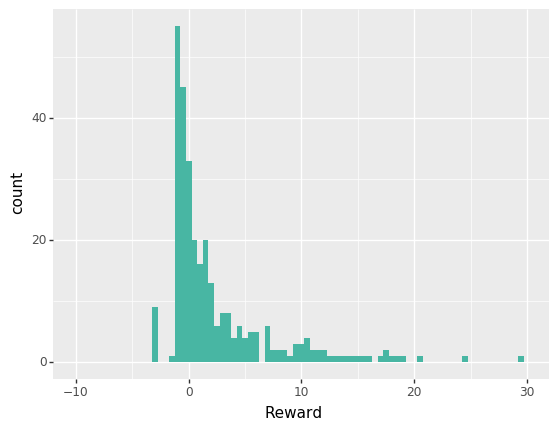

<ggplot: (-9223371902361442486)>

In [12]:
ggplot(df,aes(x='Reward'))+\
geom_histogram(binwidth=0.5,fill='#48b6a3')+\
xlim(-10,30)

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 35 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


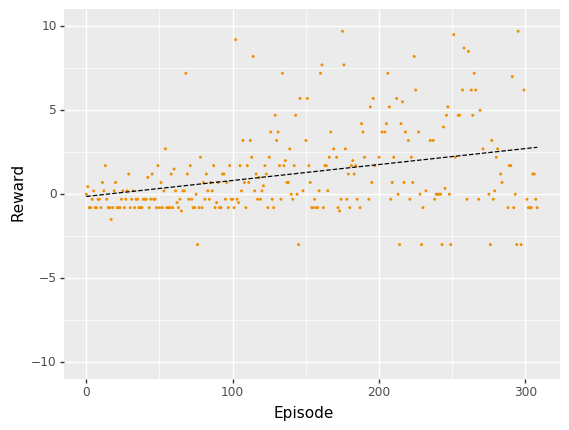

<ggplot: (134527971862)>

In [13]:
ggplot(df, aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(-10,10)

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


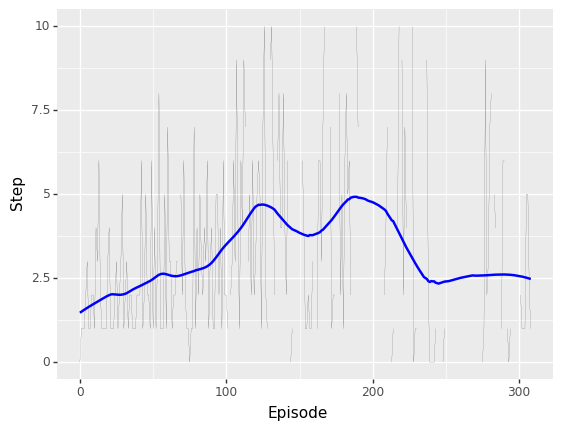

<ggplot: (-9223371902326803796)>

In [14]:
ggplot(df, aes(x='Episode',y='Step'))+ \
    geom_line(size=0.05) +\
    stat_smooth(colour='blue', span=0.2)+\
        ylim(0,10)

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 19 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


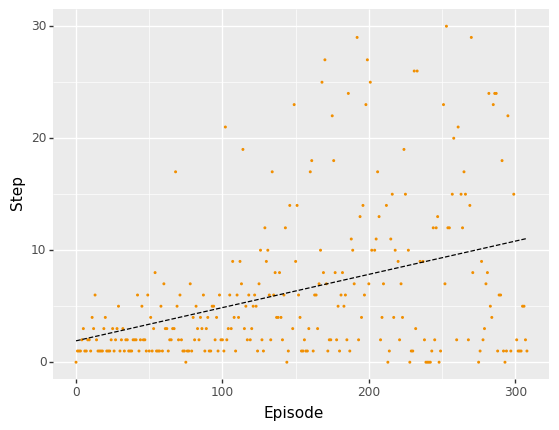

<ggplot: (134528377555)>

In [15]:
ggplot(df, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(0,30)

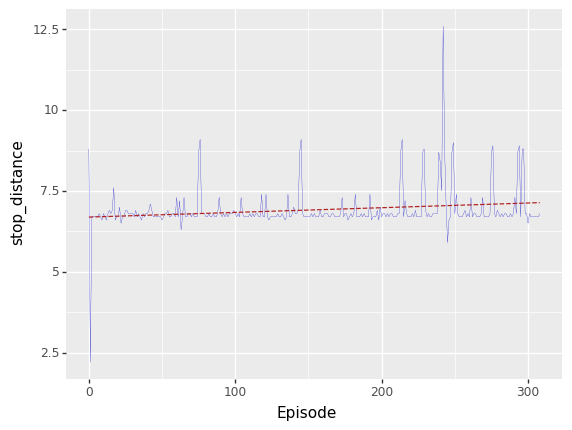

<ggplot: (-9223371902326461545)>

In [16]:
ggplot(df, aes(x='Episode',y='stop_distance'))+ \
  geom_line(size=0.1,color='mediumblue') +\
    geom_smooth(method="lm",color='firebrick', se=False, size=0.5, linetype="dashed")

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


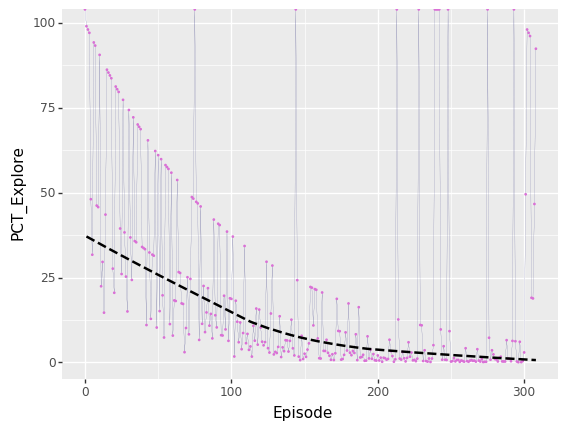

<ggplot: (134528345194)>

In [17]:
ggplot(df, aes(x='Episode',y='PCT_Explore'))+ \
  geom_line(color='midnightblue',size=0.05) +\
    geom_point(color="orchid", size=0.1)+\
    geom_smooth( size=1, linetype="dashed")

# Save data and q_table

In [18]:
name='brake_test_1' ##INSERT FILE NAME
file_path="DATA\\ "
df.to_csv(file_path+'{}.csv'.format(name))
df_q.to_csv(file_path+'{}_q_table.csv'.format(name))

In [19]:
close_carla()